### Setup

Below setup code is mainly from the ConvolutionalVAE notebook from week 4

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

from keras.layers import Lambda, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

from keras.models import Model
from keras.losses import mse, binary_crossentropy

from keras import backend as K


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Importing datasets

Import the villagers images dataset

Import the villagers information dataset

In [3]:
directory = "villagers"

img_files = []
img_files += [os.path.join(directory, img) for img in os.listdir(directory)]

#print(img_files)

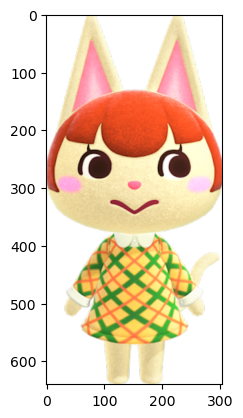

In [4]:
img = plt.imread(img_files[88])
plt.imshow(img)

### Processing of data

-ChatGPT help

In [5]:
# Resize the images
villagers_imgs = []
height = 640
width = 400

for file in img_files:
    
    #skip bc of weird file
    if(file==(directory + "/.DS_Store")):
        continue
    
    #plt.figure()
    img = plt.imread(file)
    img = cv2.resize(img, (width, height))
    #print(img.shape)
    #plt.imshow(img)
    #plt.plot()
    
    villagers_imgs.append(img)

villagers_array = np.array(villagers_imgs)

### Creating train and test sets 



(313, 640, 400, 4)
(79, 640, 400, 4)


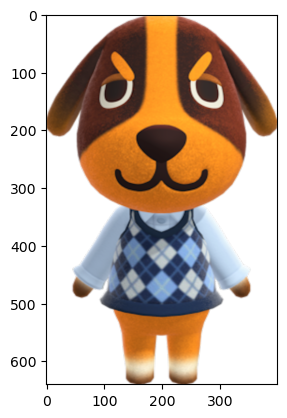

In [6]:
X_train, X_test = train_test_split(villagers_array, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

plt.imshow(X_test[1])


In [7]:
#X_train = X_train.astype('float32') / 255.
#X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)
(313, 1024000)
(79, 1024000)


### Building a simple autoencoder as a start

Using this tutorial from keras "Let's build the simplest possible autoencoder": https://blog.keras.io/building-autoencoders-in-keras.html

In [8]:
encoding_dim = 64
#input_shape = (640, 400, 4)
input_shape=(1024000,)

epochs = 50
batch_size = 64

inputs = Input(shape=input_shape)

encoded = Dense(encoding_dim, activation='relu')(inputs)
decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

# input -> reconstruction 
autoencoder = Model(inputs, decoded)
print(decoded.shape)

# Encoder
# input -> encoded representation
encoder = Model(inputs, encoded)

# Decoder
encoded_input = Input(shape=encoding_dim)

# last layer of autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create decoder model
# encoded rep -> reconstruction 
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compilation
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
                shuffle=True, validation_data=(X_test, X_test))


Metal device set to: Apple M1 Max
(None, 1024000)
Epoch 1/50


2023-06-05 12:06:51.863399: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 2s 286ms/step - loss: 0.6493 - val_loss: 0.5635
Epoch 2/50
5/5 [==============================] - 1s 178ms/step - loss: 0.5262 - val_loss: 0.5204
Epoch 3/50
5/5 [==============================] - 1s 186ms/step - loss: 0.5072 - val_loss: 0.5188
Epoch 4/50
5/5 [==============================] - 1s 173ms/step - loss: 0.5024 - val_loss: 0.5138
Epoch 5/50
5/5 [==============================] - 1s 185ms/step - loss: 0.4987 - val_loss: 0.5104
Epoch 6/50
5/5 [==============================] - 1s 180ms/step - loss: 0.4937 - val_loss: 0.5039
Epoch 7/50
5/5 [==============================] - 1s 174ms/step - loss: 0.4853 - val_loss: 0.4955
Epoch 8/50
5/5 [==============================] - 1s 178ms/step - loss: 0.4740 - val_loss: 0.4868
Epoch 9/50
5/5 [==============================] - 1s 178ms/step - loss: 0.4624 - val_loss: 0.4780
Epoch 10/50
5/5 [==============================] - 1s 170ms/step - loss: 0.4529 - val_loss: 0.4728
Epoch 11/50
5/5 [=============

### Visualise results

In [9]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

3/3 [==============================] - 0s 10ms/step


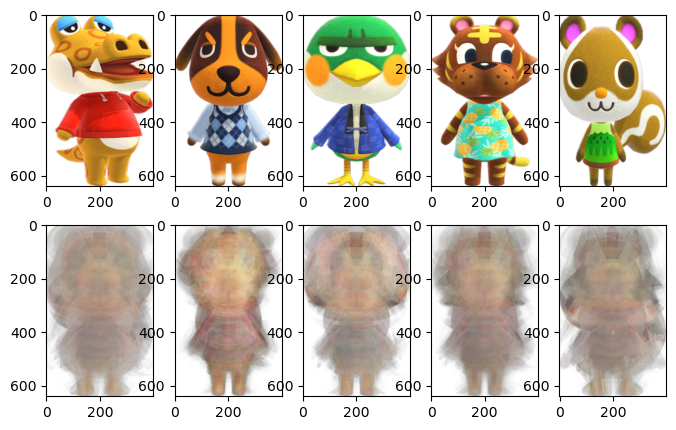

In [10]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(decoded_imgs[i].reshape(height, width, 4))

plt.show()

### Some notes on the results

1. Using an encoding_dim value of 32 leads to a loss of 0.4498, and images that aren't so accurate
2. Using an encoding_dim value of 64 leads to a loss of 0.4318 (binary_crossentropy) 